<a href="https://colab.research.google.com/github/livalgo/interactive-pipe-examples/blob/main/interactive_pipe_cache_curves_MLP_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⏯ [`interactive_pipe` website](https://balthazarneveu.github.io/interactive_pipe/)

![](https://balthazarneveu.github.io/interactive_pipe/static/interact-pipe-logo-horizontal-rgb.svg)


# Full tutorial on curves and cache mechanism

**Note** : The same tutorial is also available on [🤗 HF spaces](https://huggingface.co/spaces/balthou/interactive-pipe-neural-networks-and-curves)

In [ ]:
# Mandatory installation.
!pip install "ipywidgets>=7,<8"
!pip install interactive-pipe>=0.7.8

In [2]:
import torch
from copy import deepcopy
from interactive_pipe import (
    interactive, interactive_pipeline,
    Curve, SingleCurve
)
import argparse
import numpy as np
from interactive_pipe.helper import _private

# Cache mechanism
- Required to avoid performing "model training" (even if small).
- Save epochs results into `context`, plot inference without re-performing training.

In [8]:
_private.registered_controls_names = [] # this is for notebooks where you re-execute cells everytime.

# ⚠️ Using the cache mechanism is mandatory for this example...

# --------------------------------
# . Processing blocks definition .
# --------------------------------
SAVE_FREQUENCY = 10


@interactive(
    lr=(-2., [-5., 0.], "log10 learning rate"),
    seed=(42, [0, 100]),
)
def set_learning_rate(lr: float = -3, seed=42, context: dict = {}):
    context["lr"] = 10.**lr
    torch.manual_seed(seed)


@interactive(
    hidden_dimension=(3, [1, 10])
)
def define_network(seed: int = 42, hidden_dimension=2, context: dict = {}):

    context["model"] = torch.nn.Sequential(
        torch.nn.Linear(1, hidden_dimension),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dimension, 1)
    )


def get_input_points() -> torch.Tensor:
    return torch.linspace(-1, 1, 100)[:, None]


def target_function(x: torch.Tensor) -> torch.Tensor:
    return torch.abs(x-0.3) + (x+0.3)**2 - 1.


def fit_model(
    x: torch.Tensor,
    y: torch.Tensor,
    context: dict = {},
) -> np.ndarray:
    saved_models = {}
    model = context['model']
    losses = []
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=context.get("lr", 0.01))
    # Let's keep the model every 10 / 100 iterations!
    # This optimization loop will be cached by the interactive pipeline
    # and not recomputed at each call of the pipeline.
    # (unless you change the hidden layer dimension for instance)
    # We'll visualize the loss evolution and the fitting result afterwards.
    for epoch in range(401):
        if epoch % SAVE_FREQUENCY == 0:
            saved_models[epoch] = deepcopy(model.state_dict())
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    context['saved_models'] = saved_models
    return np.array(losses)


@interactive(selected_iteration=(100, [0, 400]))
def select_iteration(context: dict = {}, selected_iteration: int = 0):
    context["selected_iteration"] = selected_iteration
    # dedicated interactive block to select the iteration
    # as 2 later blocks (plot_prediction_curve & ) will depend on this value.


def plot_prediction_curve(
    context: dict = {},
) -> SingleCurve:
    iter = np.round(context.get("selected_iteration", 0) /
                    SAVE_FREQUENCY) * SAVE_FREQUENCY
    model = context['model']
    model.load_state_dict(context['saved_models'][iter])
    inp = torch.linspace(-2, 2, 100)[:, None]
    out = model(inp).detach().numpy()
    pred = SingleCurve(
        x=inp.numpy(),
        y=out,
        style=".r",
        label=f"Fit - Iteration {iter}"
    )
    return pred


def plot_target_curve(x: torch.Tensor, y: torch.Tensor) -> SingleCurve:
    target = SingleCurve(
        x=x,
        y=y.detach(),
        style="b",
        linestyle='-',
        label="Target"
    )
    return target


def plot_loss(losses: np.ndarray, context={}) -> Curve:
    iter = context.get("selected_iteration", 0)
    return Curve([
        SingleCurve(
            x=range(len(losses)),
            y=losses,
            style="g",
            label=f"Loss {losses[iter]:.4f}"
        ),
        SingleCurve(
            x=[iter]*2,
            y=[0, losses[iter]],
            style="ro",
            linestyle="-",
            label=f"Selected iteration = {iter} "
        )
    ],
        grid=True,
        title=f"Loss evolution lr={context['lr']:.4f}"
    )


def compare_curves(pred, target):
    return Curve(
        [pred, target],
        xlim=(-2, 2),
        ylim=(-1, 2),
        grid=True,
        title="Fitting result"
    )

# -----------------------
# . Pipeline definition .
# -----------------------


def visualize_regression_of_a_neural_network():
    x = get_input_points()
    y = target_function(x)
    target_curve = plot_target_curve(x, y)
    set_learning_rate()
    define_network()
    losses = fit_model(x, y)
    select_iteration()
    losses_curve = plot_loss(losses)
    prediction_curve = plot_prediction_curve()

    output_fit = compare_curves(prediction_curve, target_curve)
    return [output_fit, losses_curve]


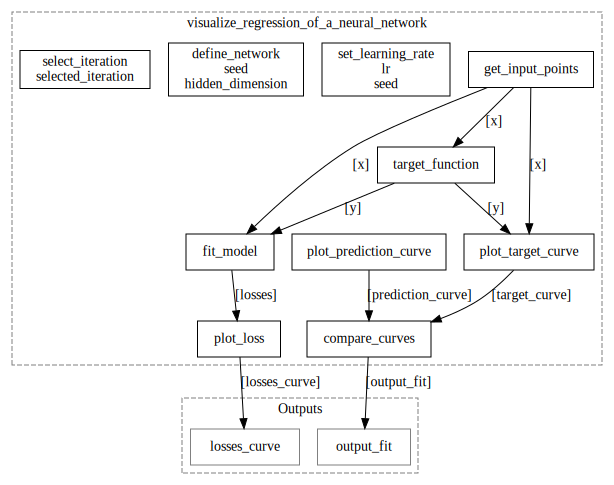

In [18]:
headless_pipe = interactive_pipeline(gui=None)(visualize_regression_of_a_neural_network)
headless_pipe.graph_representation(ortho=False)

interactive(children=(FloatSlider(value=-2.0, description='log10 learning rate', layout=Layout(width='500px'),…

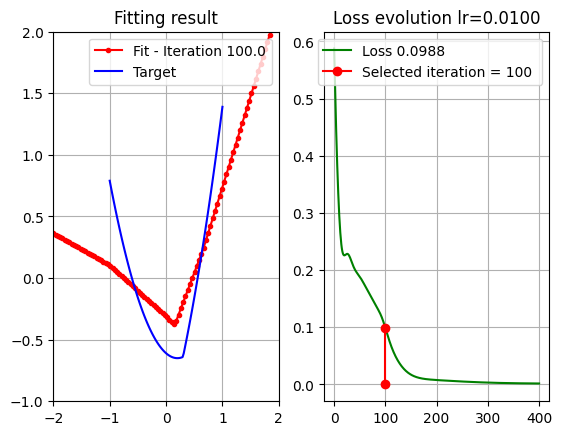

In [10]:
interactive_pipeline(
    gui="nb",
    cache=True,
)(visualize_regression_of_a_neural_network)();